<a href="https://colab.research.google.com/github/avyayv/lineups_ml/blob/main/SportsAnalyticsFinalPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Acknowledgements: Some of the RAPM preprocessing / modeling code is taken from Ryan Davis (rd11490 on GitHub). It is changed to fit our needs.

In [ ]:
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from torch.nn import MSELoss

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# Connect to Google Drive
device = torch.device('cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Evaluation Metrics

In [ ]:
# calculate rmse on test set
def calculate_rmse(model, test_loader):
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            all_outputs.append(outputs.numpy())
            all_labels.append(labels.numpy())
    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)
    return mean_squared_error(all_labels, all_outputs, squared=False)

# Helper Functions

In [ ]:
def build_player_list(posessions):
    players = list(
        set(list(posessions['offensePlayer1Id'].unique()) + list(posessions['offensePlayer2Id'].unique()) + list(
            posessions['offensePlayer3Id']) + \
            list(posessions['offensePlayer4Id'].unique()) + list(posessions['offensePlayer5Id'].unique()) + list(
            posessions['defensePlayer1Id'].unique()) + \
            list(posessions['defensePlayer2Id'].unique()) + list(posessions['defensePlayer3Id'].unique()) + list(
            posessions['defensePlayer4Id'].unique()) + \
            list(posessions['defensePlayer5Id'].unique())))
    players.sort()
    return players

In [ ]:
def map_players_rapm(row_in, players):
    rowOut = np.zeros([len(players) * 2])
    for player in row_in:
        index = players.index(player)
        rowOut[index] = 1
    for player in row_in[5:]:
        index = players.index(player)
        rowOut[index + len(players)] = -1
    return rowOut

In [ ]:
def convert_to_matricies(possessions, name, players):

    stints_x_base = possessions[['offensePlayer1Id',
                                 'offensePlayer2Id',
                                 'offensePlayer3Id',
                                 'offensePlayer4Id',
                                 'offensePlayer5Id',
                                 'defensePlayer1Id',
                                 'defensePlayer2Id',
                                 'defensePlayer3Id',
                                 'defensePlayer4Id',
                                 'defensePlayer5Id']].values

    stint_X_rows = np.apply_along_axis(map_players_rapm, 1, stints_x_base, players)
    stint_Y_rows = possessions[[name]].values
    possessions = possessions['possessions']
    return stint_X_rows, stint_Y_rows, possessions

def map_players(row_in, players):
    rowOut = np.zeros(10)
    for i in range(10):
        rowOut[i] = players.index(row_in[i])
    return rowOut

def convert_to_matrices_nn(possessions, name, players):

    stints_x_base = possessions[['offensePlayer1Id',
                                 'offensePlayer2Id',
                                 'offensePlayer3Id',
                                 'offensePlayer4Id',
                                 'offensePlayer5Id',
                                 'defensePlayer1Id',
                                 'defensePlayer2Id',
                                 'defensePlayer3Id',
                                 'defensePlayer4Id',
                                 'defensePlayer5Id']].to_numpy()

    stint_X_rows = np.apply_along_axis(map_players, 1, stints_x_base, players)
    stint_Y_rows = possessions[[name]].to_numpy()
    possessions = possessions['possessions']
    return stint_X_rows, stint_Y_rows, possessions

In [ ]:
def map_players_nn(row_in, players):
    rowOut = np.zeros(10)
    for i in range(10):
        rowOut[i] = players.index(row_in[i])
    return rowOut

In [ ]:
def lambda_to_alpha(lambda_value, samples):
    return (lambda_value * samples) / 2.0

def alpha_to_lambda(alpha_value, samples):
    return (alpha_value * 2.0) / samples

In [ ]:
import matplotlib.pyplot as plt

def plot_players_given_two_components(names, rtg1, rtg2, rtg1_label, rtg2_label, names_to_plot=[]):
    plt.scatter(rtg1, rtg2, alpha=0.3)
    plt.xlabel(rtg1_label)
    plt.ylabel(rtg2_label)

    for i, name in enumerate(names):
        if name in names_to_plot:
            plt.annotate(name, (rtg1[i], rtg2[i]))

    plt.show()

# Loading Data

In [ ]:
train_possessions = pd.read_csv('drive/MyDrive/sportsanalytics/train_possessions.csv')
test_possessions = pd.read_csv('drive/MyDrive/sportsanalytics/test_possessions.csv')
player_names = pd.read_csv('drive/MyDrive/sportsanalytics/player_names.csv')

train_possessions = train_possessions[train_possessions['possessions'] > 0]
test_possessions = test_possessions[test_possessions['possessions'] > 0]

train_possessions['PointsPerPossession'] = 100 * train_possessions['points'] / train_possessions['possessions']
test_possessions['PointsPerPossession'] = 100 * test_possessions['points'] / test_possessions['possessions']

In [ ]:
player_list = build_player_list(train_possessions)

# RAPM Model

In [ ]:
def calculate_rapm(train_x, train_y, possessions, lambdas, name, players):
    alphas = [lambda_to_alpha(l, train_x.shape[0]) for l in lambdas]
    clf = RidgeCV(alphas=alphas, cv=5, fit_intercept=True)
    model = clf.fit(train_x, train_y, sample_weight=possessions)
    player_arr = np.transpose(np.array(players).reshape(1, len(players)))
    coef_offensive_array = np.transpose(model.coef_[:, 0:len(players)])
    coef_defensive_array = np.transpose(model.coef_[:, len(players):])
    player_id_with_coef = np.concatenate([player_arr, coef_offensive_array, coef_defensive_array], axis=1)
    players_coef = pd.DataFrame(player_id_with_coef)
    intercept = model.intercept_
    players_coef.columns = ['playerId', '{0}__Off'.format(name), '{0}__Def'.format(name)]
    players_coef[name] = players_coef['{0}__Off'.format(name)] + players_coef['{0}__Def'.format(name)]
    players_coef['{0}_Rank'.format(name)] = players_coef[name].rank(ascending=False)
    players_coef['{0}__Off_Rank'.format(name)] = players_coef['{0}__Off'.format(name)].rank(ascending=False)
    players_coef['{0}__Def_Rank'.format(name)] = players_coef['{0}__Def'.format(name)].rank(ascending=False)
    players_coef['{0}__intercept'.format(name)] = intercept[0]
    return model, players_coef, intercept

In [ ]:
train_x, train_y, possessions_raw = convert_to_matricies(train_possessions, 'PointsPerPossession', player_list)

In [ ]:
lambdas_rapm = [.01, .05, .1]
model, results, intercept = calculate_rapm(train_x, train_y, possessions_raw, lambdas_rapm, 'RAPM', player_list)
results = np.round(results, decimals=2)
results = player_names.merge(results, how='inner', on='playerId')

### Evaluation

In [ ]:
test_x, test_y, possessions_raw = convert_to_matricies(test_possessions, 'PointsPerPossession', player_list)
test_predictions = model.predict(test_x)
train_predictions = model.predict(train_x)

In [ ]:
test_rmse = math.sqrt(mean_squared_error(test_y, test_predictions))
train_rmse = math.sqrt(mean_squared_error(train_y, train_predictions))

In [ ]:
train_rmse, test_rmse

(116.96372780358936, 117.36393199123769)

### View Ratings

In [ ]:
print(results[["playerName", "RAPM", "RAPM__Off", "RAPM__Def"]].sort_values(by='RAPM', ascending=False).head(5).to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
   playerName &  RAPM &  RAPM\_\_Off &  RAPM\_\_Def \\
\midrule
 Kevin Durant &  4.93 &       2.87 &       2.06 \\
  Danny Green &  4.71 &       2.08 &       2.63 \\
Stephen Curry &  4.13 &       2.05 &       2.08 \\
  Paul George &  3.62 &       1.15 &       2.47 \\
 James Harden &  3.35 &       2.53 &       0.82 \\
\bottomrule
\end{tabular}



<ipython-input-120-cca06af7e919>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results[["playerName", "RAPM", "RAPM__Off", "RAPM__Def"]].sort_values(by='RAPM', ascending=False).head(5).to_latex(index=False))


In [ ]:
results.sort_values(by='RAPM__Off', ascending=False).head(5)

,playerId,playerName,RAPM__Off,RAPM__Def,RAPM,RAPM_Rank,RAPM__Off_Rank,RAPM__Def_Rank,RAPM__intercept
397,202722,Davis Bertans,2.93,0.25,3.17,5.0,1.0,164.0,111.16
292,201142,Kevin Durant,2.90,1.93,4.83,1.0,2.0,7.0,111.16
328,201935,James Harden,2.77,1.03,3.80,4.0,3.0,39.0,111.16
346,201988,Patty Mills,2.64,-0.05,2.59,15.0,4.0,278.0,111.16
492,203939,Dwight Powell,2.27,-0.75,1.52,37.0,5.0,468.0,111.16


In [ ]:
results.sort_values(by='RAPM__Def', ascending=False).head(5)

,playerId,playerName,RAPM__Off,RAPM__Def,RAPM,RAPM_Rank,RAPM__Off_Rank,RAPM__Def_Rank,RAPM__intercept
345,201980,Danny Green,1.83,2.51,4.34,2.0,8.0,1.0,111.16
358,202331,Paul George,0.81,2.27,3.08,6.0,63.0,2.0,111.16
361,202339,Eric Bledsoe,0.58,2.22,2.80,10.0,108.0,3.0,111.16
93,1627783,Pascal Siakam,0.81,2.21,3.02,8.0,64.0,4.0,111.16
460,203507,Giannis Antetokounmpo,0.48,2.18,2.66,12.0,126.0,5.0,111.16


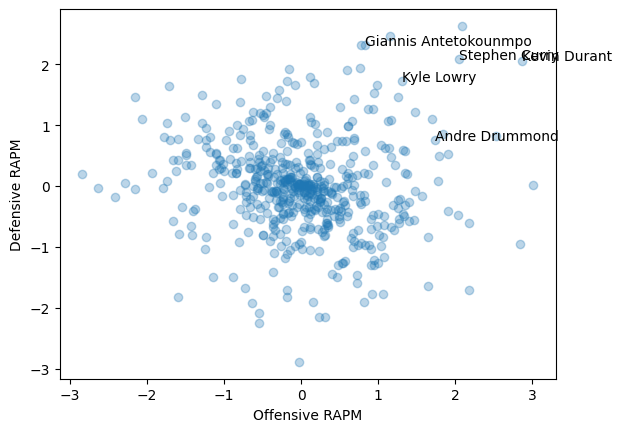

In [ ]:
plot_players_given_two_components(results["playerName"], results["RAPM__Off"], results["RAPM__Def"], "Offensive RAPM", "Defensive RAPM", ["Stephen Curry", "Kevin Durant", "Giannis Antetokounmpo", "Kyle Lowry", "Andre Drummond"])

# Neural Networks

## Setup

In [ ]:
# split train into train and validation
train_possessions = train_possessions.sample(frac=1, random_state=42)
train_possessions, validation_possessions = train_possessions.iloc[:int(len(train_possessions) * 0.8)], train_possessions.iloc[int(len(train_possessions) * 0.8):]

In [ ]:
train_x, train_y, train_possessions_raw = convert_to_matrices_nn(train_possessions, 'PointsPerPossession', player_list)
val_x, val_y, val_possessions_raw = convert_to_matrices_nn(validation_possessions, 'PointsPerPossession', player_list)
test_x, test_y, test_possessions_raw = convert_to_matrices_nn(test_possessions, 'PointsPerPossession', player_list)

In [ ]:
train_x_tensor = torch.tensor(train_x, dtype=torch.long, device=device)
train_y_tensor = torch.tensor(train_y, dtype=torch.float, device=device)
test_x_tensor = torch.tensor(test_x, dtype=torch.long, device=device)
test_y_tensor = torch.tensor(test_y, dtype=torch.float, device=device)
val_x_tensor = torch.tensor(val_x, dtype=torch.long, device=device)
val_y_tensor = torch.tensor(val_y, dtype=torch.float, device=device)

In [ ]:
# create dataset
train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_y_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_y_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_y_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
# Set the number of training epochs
def train(optimizer, criterion, net, max_patience=5, num_epochs=100, model_path="model.pth"):
    # Training loop
    patience = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)

        # validation loss
        val_loss = 0.0
        for inputs, labels in val_loader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss = val_loss / len(val_loader)

        # early stopping
        if epoch == 0:
            torch.save(net.state_dict(), model_path)
            best_loss = val_loss
        else:
            if val_loss < best_loss:
                torch.save(net.state_dict(), model_path)
                best_loss = val_loss
                patience = 0
            else:
                patience += 1
                if patience == max_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Val Loss: {val_loss}")

## MLP (NBA2Vec)

### Architecture

In [ ]:
class NBA2Vec(nn.Module):
    def __init__(self, player_dim=50, dropout=0.2):
        super(NBA2Vec, self).__init__()
        self.embedding = nn.Embedding(len(player_list), player_dim)
        self.fc1 = nn.Linear(player_dim * 2, player_dim)
        self.fc2 = nn.Linear(player_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x1 = torch.mean(x[:, :5, :], dim=1)
        x2 = torch.mean(x[:, 5:, :], dim=1)
        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Experiments

In [ ]:
player_dims = [15, 35, 50, 100]
dropout = [0, 0.05, 0.1, 0.2]

In [ ]:
def plot_different_dropouts(dropouts):
  val_rmses = []
  criterion = MSELoss()
  for dropout in dropouts:
    mlp = NBA2Vec(player_dim=50, dropout=dropout)
    optimizer = optim.Adam(mlp.parameters(), lr=0.001)
    train(optimizer, criterion, mlp, num_epochs=100, model_path=f"mlp_{dropout}.pth")
    val_rmse = calculate_rmse(mlp, val_loader)
    val_rmses.append(val_rmse)
  return dict(zip(dropouts, val_rmses))

def plot_different_dims(dims):
  val_rmses = []
  criterion = MSELoss()
  for dim in dims:
    mlp = NBA2Vec(player_dim=dim, dropout=0)
    optimizer = optim.Adam(mlp.parameters(), lr=0.001)
    train(optimizer, criterion, mlp, num_epochs=100, model_path=f"mlp_player_dim_{dim}.pth")
    val_rmse = calculate_rmse(mlp, val_loader)
    val_rmses.append(val_rmse)
  return dict(zip(dims, val_rmses))

In [ ]:
res = plot_different_dropouts(dropout)

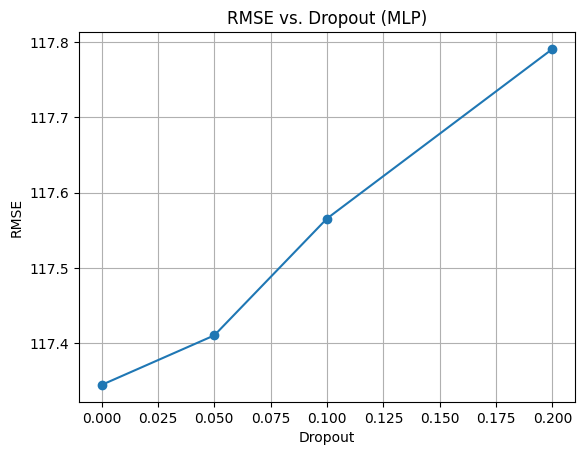

In [ ]:
x = list(res.keys())
y = list(res.values())

plt.plot(x, y, marker='o')
plt.xlabel('Dropout')
plt.ylabel('RMSE')
plt.title('RMSE vs. Dropout (MLP)')
plt.grid(True)
plt.show()

In [ ]:
res = plot_different_dims(player_dims)

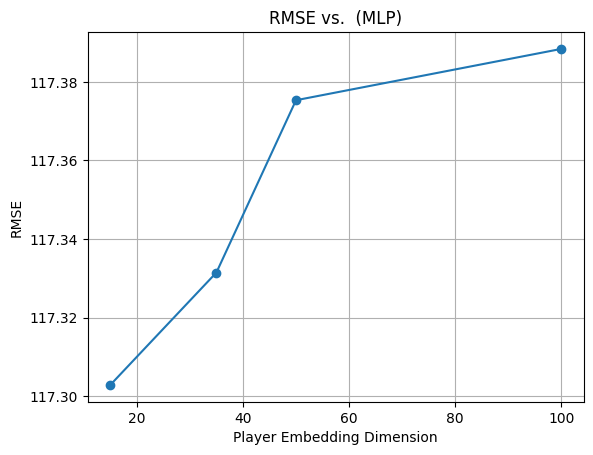

In [ ]:
x = list(res.keys())
y = list(res.values())

plt.plot(x, y, marker='o')
plt.xlabel('Player Embedding Dimension')
plt.ylabel('RMSE')
plt.title('RMSE vs.  (MLP)')
plt.grid(True)
plt.show()

### Final Model

In [ ]:
mlp = NBA2Vec(player_dim=15, dropout=0.0)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = MSELoss()
train(optimizer, criterion, mlp, num_epochs=100, model_path=f"mlp_final.pth")

Epoch 1/100, Loss: 16781.854844456142, Val Loss: 13867.19371157787
Epoch 2/100, Loss: 13778.099461727095, Val Loss: 13817.604095158811
Epoch 3/100, Loss: 13740.750129191916, Val Loss: 13798.134679175206
Epoch 4/100, Loss: 13719.823752535693, Val Loss: 13787.887323898565
Epoch 5/100, Loss: 13708.997261291855, Val Loss: 13779.408100665984
Epoch 6/100, Loss: 13699.392245917214, Val Loss: 13776.829216828894
Epoch 7/100, Loss: 13692.401757972986, Val Loss: 13773.832633196722
Epoch 8/100, Loss: 13686.752489953524, Val Loss: 13778.34715996414
Epoch 9/100, Loss: 13682.539789505443, Val Loss: 13772.995472592213
Epoch 10/100, Loss: 13679.225234471292, Val Loss: 13773.06231109119
Epoch 11/100, Loss: 13675.631989202444, Val Loss: 13772.948600794058
Epoch 12/100, Loss: 13672.97405409049, Val Loss: 13773.126245517418
Epoch 13/100, Loss: 13669.193714050945, Val Loss: 13771.364309042008
Epoch 14/100, Loss: 13666.591653239268, Val Loss: 13770.562038934426
Epoch 15/100, Loss: 13665.799798268026, Val Los

In [ ]:
test_rmse = calculate_rmse(mlp, test_loader)
train_rmse = calculate_rmse(mlp, train_loader)
train_rmse, test_rmse

(116.80392, 117.50328)

## Proposed Approach (Transformer)

### Model Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TransformerModel(nn.Module):

    def __init__(self,
                 num_players=len(player_list),
                 max_sequence_length=10,
                 dropout=0.3,
                 d_model=50,
                 num_layers=2,
                 hidden_size=50,
                 num_classes=1):

        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(num_players, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_sequence_length)
        self.cls_embedding = nn.Parameter(torch.randn(1, 1, d_model))
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead=5, dim_feedforward=hidden_size, dropout=dropout),
            num_layers
        )
        self.mlp = nn.Sequential(
            nn.Linear(d_model, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, player_ids):
        batch_size, seq_len = player_ids.size()
        player_embeddings = self.embedding(player_ids)  # Embedding lookup
        positional_encoding = self.positional_encoding(seq_len)
        player_embeddings += positional_encoding
        cls_embedding = self.cls_embedding.expand(batch_size, 1, -1)
        sequence_embeddings = torch.cat([cls_embedding, player_embeddings], dim=1)
        encoded_sequence = self.transformer_encoder(sequence_embeddings.transpose(0, 1))
        cls_embedding = encoded_sequence[0]  # First position
        output = self.mlp(cls_embedding)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(0, max_sequence_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        positional_encoding = torch.zeros(max_sequence_length, d_model)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('positional_encoding', positional_encoding.unsqueeze(0))

    def forward(self, seq_len):
        return self.positional_encoding[:, :seq_len]

### Experiments

In [ ]:
player_dims = [20, 50, 100]
dropouts = [0, 0.1, 0.3]
num_hidden_layers = [2,4,8]

In [ ]:
def plot_different_dropouts(dropouts):
  val_rmses = []
  criterion = MSELoss()
  for dropout in dropouts:
    tra = TransformerModel(dropout=dropout)
    optimizer = optim.Adam(tra.parameters(), lr=0.001)
    train(optimizer, criterion, tra, num_epochs=100, model_path=f"transformer_{dropout}.pth")
    val_rmse = calculate_rmse(tra, val_loader)
    val_rmses.append(val_rmse)
  return dict(zip(dropouts, val_rmses))

def plot_different_dims(dims):
  val_rmses = []
  criterion = MSELoss()
  for dim in dims:
    tra = TransformerModel(d_model=dim)
    optimizer = optim.Adam(tra.parameters(), lr=0.001)
    train(optimizer, criterion, tra, num_epochs=100, model_path=f"transformer_player_dim_{dim}.pth")
    val_rmse = calculate_rmse(tra, val_loader)
    val_rmses.append(val_rmse)
  return dict(zip(dims, val_rmses))

def plot_different_encoder_layers(n_layers):
  val_rmses = []
  criterion = MSELoss()
  for n in n_layers:
    tra = TransformerModel(num_layers=n)
    optimizer = optim.Adam(tra.parameters(), lr=0.001)
    train(optimizer, criterion, tra, num_epochs=100, model_path=f"transformer_player_dim_{n}.pth")
    val_rmse = calculate_rmse(tra, val_loader)
    val_rmses.append(val_rmse)
  return dict(zip(n_layers, val_rmses))

In [ ]:
res = plot_different_dims(player_dims)

Epoch 1/100, Loss: 15134.565031680104, Val Loss: 13759.372108734631
Epoch 2/100, Loss: 13727.525474880598, Val Loss: 13753.609323770492
Epoch 3/100, Loss: 13725.805327842543, Val Loss: 13767.201293545082
Epoch 4/100, Loss: 13726.766536565325, Val Loss: 13756.729098360656
Epoch 5/100, Loss: 13723.923037727249, Val Loss: 13753.33299180328
Epoch 6/100, Loss: 13725.316636548634, Val Loss: 13774.13168545082
Epoch 7/100, Loss: 13720.149125186164, Val Loss: 13763.649788678278
Epoch 8/100, Loss: 13711.513570768282, Val Loss: 13764.829501793032
Epoch 9/100, Loss: 13707.126905781379, Val Loss: 13803.00900678791
Early stopping at epoch 10
Epoch 1/100, Loss: 14662.607080840438, Val Loss: 13767.756711065575
Epoch 2/100, Loss: 13729.176184874435, Val Loss: 13756.573728867828
Epoch 3/100, Loss: 13731.051644669269, Val Loss: 13754.11317558914
Epoch 4/100, Loss: 13728.170258094957, Val Loss: 13755.893926101435
Epoch 5/100, Loss: 13722.15258849245, Val Loss: 13755.072099129098
Epoch 6/100, Loss: 13719.8

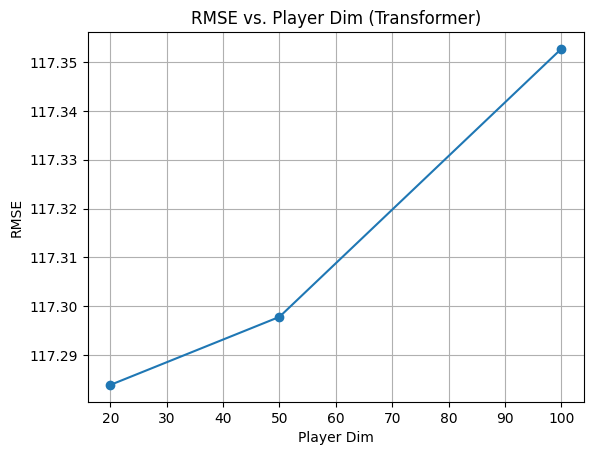

In [ ]:
x = list(res.keys())
y = list(res.values())

plt.plot(x, y, marker='o')
plt.xlabel('Player Dim')
plt.ylabel('RMSE')
plt.title('RMSE vs. Player Dim (Transformer)')
plt.grid(True)
plt.show()

In [ ]:
res2 = plot_different_dropouts(dropouts)

Epoch 1/100, Loss: 14786.638395837614, Val Loss: 13755.143170466188
Epoch 2/100, Loss: 13725.370712593724, Val Loss: 13753.951937115778
Epoch 3/100, Loss: 13724.682590707169, Val Loss: 13766.04038486168
Epoch 4/100, Loss: 13728.027849283586, Val Loss: 13754.678999103484
Epoch 5/100, Loss: 13728.01236952419, Val Loss: 13771.068589907787
Epoch 6/100, Loss: 13727.801239439965, Val Loss: 13757.025723616804
Early stopping at epoch 7
Epoch 1/100, Loss: 14728.792962330526, Val Loss: 13753.580244620902
Epoch 2/100, Loss: 13729.572534440478, Val Loss: 13768.665548155737
Epoch 3/100, Loss: 13727.487056735312, Val Loss: 13752.199548539958
Epoch 4/100, Loss: 13722.762970547452, Val Loss: 13750.641761654713
Epoch 5/100, Loss: 13717.389133274703, Val Loss: 13750.533167904714
Epoch 6/100, Loss: 13704.208023861185, Val Loss: 13760.065977202868
Epoch 7/100, Loss: 13695.542114157508, Val Loss: 13765.834163678279
Epoch 8/100, Loss: 13694.254684611236, Val Loss: 13774.003579661885
Epoch 9/100, Loss: 13692

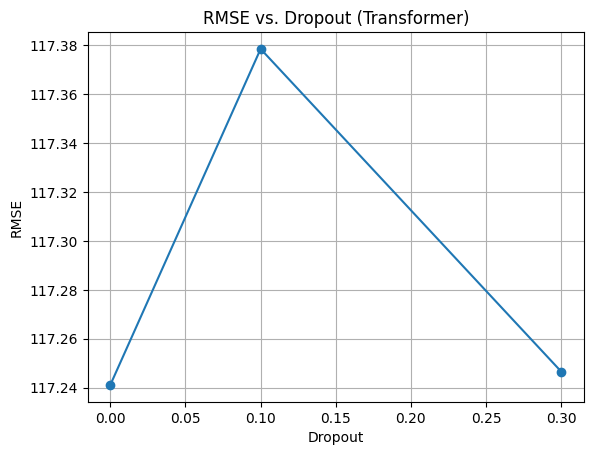

In [ ]:
x = list(res2.keys())
y = list(res2.values())

plt.plot(x, y, marker='o')
plt.xlabel('Dropout')
plt.ylabel('RMSE')
plt.title('RMSE vs. Dropout (Transformer)')
plt.grid(True)
plt.show()

In [ ]:
res3 = plot_different_encoder_layers(num_hidden_layers)

Epoch 1/100, Loss: 14585.637232307929, Val Loss: 13787.273949795082
Epoch 2/100, Loss: 13731.186847620942, Val Loss: 13756.206602202868
Epoch 3/100, Loss: 13731.986914704448, Val Loss: 13765.660706967214
Epoch 4/100, Loss: 13730.325923120377, Val Loss: 13758.4623046875
Epoch 5/100, Loss: 13731.692503177639, Val Loss: 13759.336193647541
Epoch 6/100, Loss: 13733.05340039544, Val Loss: 13757.206557377049
Early stopping at epoch 7
Epoch 1/100, Loss: 14702.093844687242, Val Loss: 13758.812090163934
Epoch 2/100, Loss: 13729.298003222577, Val Loss: 13759.78785220287
Epoch 3/100, Loss: 13730.40773289852, Val Loss: 13758.555276639345
Epoch 4/100, Loss: 13731.08640612161, Val Loss: 13765.541950563525
Epoch 5/100, Loss: 13731.478871905814, Val Loss: 13754.549202740778
Epoch 6/100, Loss: 13729.805763564349, Val Loss: 13763.641614369877
Epoch 7/100, Loss: 13729.59148633294, Val Loss: 13758.892965548155
Epoch 8/100, Loss: 13728.878271524496, Val Loss: 13755.936148821722
Epoch 9/100, Loss: 13729.7699

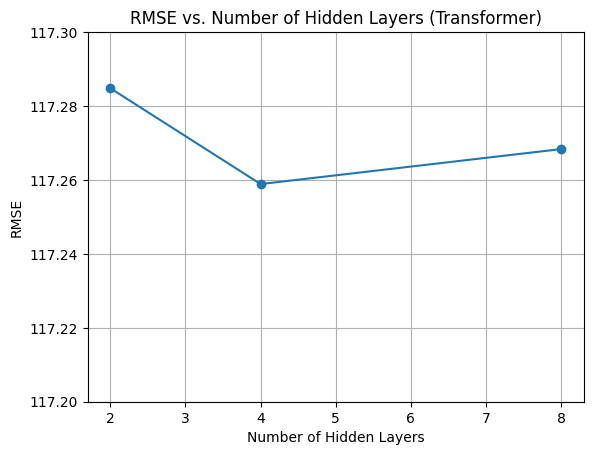

In [ ]:
x = list(res3.keys())
y = list(res3.values())

plt.plot(x, y, marker='o')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('RMSE')
plt.ylim([117.2, 117.3])
plt.yscale('linear')
plt.title('RMSE vs. Number of Hidden Layers (Transformer)')
plt.grid(True)
plt.show()

### Final Model

In [ ]:
# n_layers=4
# dropout=0.3
# player_dim=20

criterion = MSELoss()
tra = TransformerModel(dropout=0.3, d_model=20, num_layers=4)
optimizer = optim.Adam(tra.parameters(), lr=0.001)
train(optimizer, criterion, tra, num_epochs=100, model_path=f"transformer_final.pth")

Epoch 1/100, Loss: 15206.26362693868, Val Loss: 13756.560633324794
Epoch 2/100, Loss: 13727.450968056697, Val Loss: 13757.714853355532
Epoch 3/100, Loss: 13727.410214025267, Val Loss: 13761.249193135245
Epoch 4/100, Loss: 13727.755808019207, Val Loss: 13770.81330366291
Epoch 5/100, Loss: 13727.12873693637, Val Loss: 13767.252116419057
Early stopping at epoch 6


In [ ]:
test_rmse = calculate_rmse(tra, test_loader)
train_rmse = calculate_rmse(tra, train_loader)
train_rmse, test_rmse

(117.16011, 117.42489)

### tSNE

In [ ]:
# map from player id to player name
player_id_to_name = {}
for i in range(len(player_list)):
    player_name = player_names[player_names['playerId'] == player_list[i]]['playerName'].values[0]
    player_id_to_name[player_list[i]] = player_name

def get_player_name_to_embedding(model, player_list):
  # get the embeddings
  embeddings = model.embedding.weight.data.numpy()

  # get embeddings for each player
  player_embeddings = {}
  for i in range(len(player_list)):
      player_embeddings[player_list[i]] = embeddings[i]

  player_name_to_embedding = {}
  for player_id in player_id_to_name:
      player_name_to_embedding[player_id_to_name[player_id]] = player_embeddings[player_id]

  return player_name_to_embedding, embeddings

In [ ]:
embeddings = get_player_name_to_embedding(tra, player_list)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def plot_embeddings(embeddings, model, players_to_plot=["Stephen Curry",
                                                        ""]):

  player_name_to_embedding, embeddings = get_player_name_to_embedding(model, player_list)
  tsne = TSNE(n_components=2, random_state=42)
  embeddings_2d = tsne.fit_transform(embeddings)

  plt.figure(figsize=(10, 10))
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.3)
  for i in range(len(player_list)):
    player_name = player_id_to_name[player_list[i]]
    if player_name in players_to_plot:
      plt.annotate(player_name, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

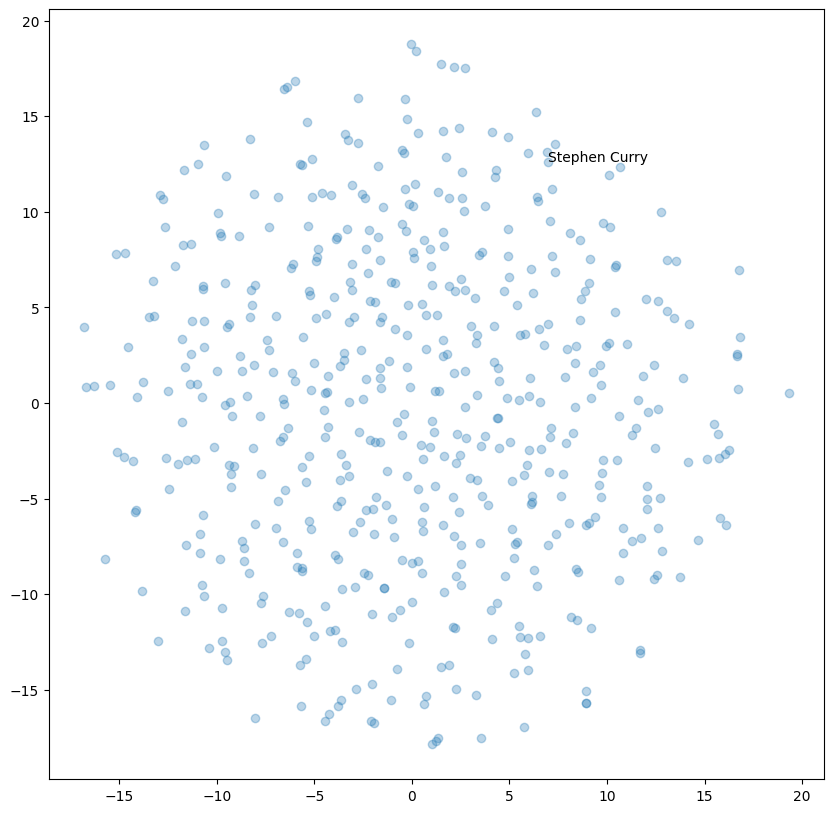

In [ ]:
plot_embeddings(embeddings, tra)

In [ ]:
# find most similar players
def find_most_similar_players(name):
    embedding = player_name_to_embedding[name]
    similarities = {}
    for player_name in player_name_to_embedding:
        similarities[player_name] = np.dot(embedding, player_name_to_embedding[player_name])/np.linalg.norm(embedding)/np.linalg.norm(player_name_to_embedding[player_name])
    return sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:10]

In [ ]:
ffin